In [1]:
import numpy as np
import hmvec as hm
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Plot settings
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

# Model

In [3]:
#Grid for Integration
Nz = 100                                 # num of redshifts
Nm = 100                                 # num of masses
Nk = 10001                                # num of wavenumbers
redshifts = np.linspace(0.01, 3, Nz)             # redshifts
masses = np.geomspace(1e11, 1e15, Nm)           # masses
ks = np.geomspace(1e-3, 100, Nk)               # wavenumbers
freq_list = [271.0]

#Initialize Halo Model
hcos = hm.HaloModel(redshifts, ks, ms=masses)

# CIB x CIB

### 3D Power Spectrum

First, let's get our 3D power spectrum.

In [4]:
#Get Power Spectra
for freq in freq_list:
    Pjj_2h = hcos.get_power_2halo("cib", "cib", nu_obs=freq)  # P(z,k)

Now let's plot it. We expect it to peak at around k = 0.02

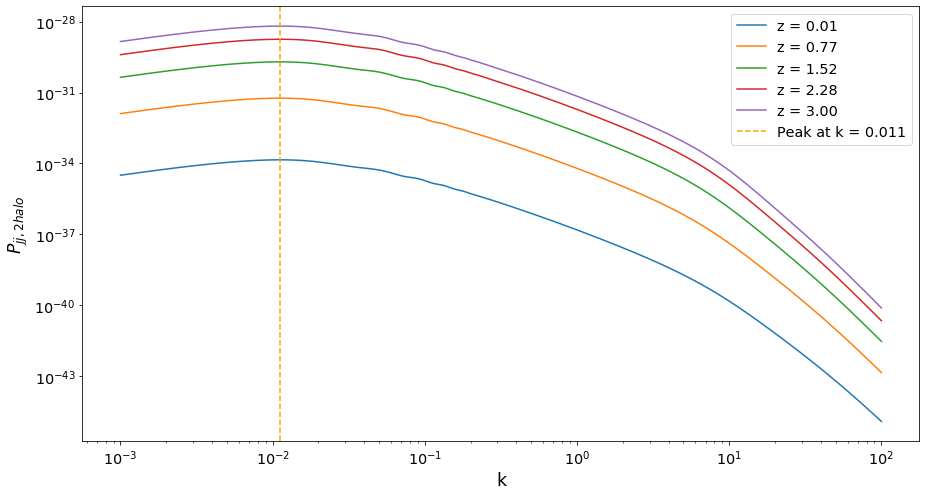

In [5]:
plt.figure(figsize=(15,8))

#Plot Power Spectra
zs = [0,25,50,75,99]                       # index of redshift you wish to plot Pjj_2h at
for zi in zs:
    plt.loglog(ks, Pjj_2h[zi,:], label=f"z = {redshifts[zi]:0.2f}")

#Plot Peak
kpeak = ks[np.argmax(Pjj_2h[0,:])]
plt.axvline(x = kpeak, ls='--', color='orange', label=f'Peak at k = {kpeak:0.3f}')

#Gravy
plt.legend()
plt.ylabel(r"$P_{jj, 2halo}$")
plt.xlabel('k')
plt.savefig('Pjj.png', dpi=500, bbox_inches='tight');

### 2D Power Spectrum

Now let's integrate along the redshift to get the 2D power spectrum.

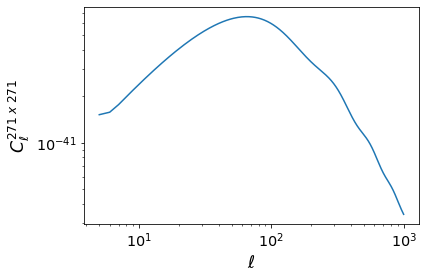

In [8]:
#Limber Integrals
Nl = 1000
ells = np.linspace(5, 1000, Nl)
Cii, Cii_integrand = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=True)

#Plot Cii
plt.loglog(ells, Cii)
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {freq_list[0]:0.0f} \;x\; {freq_list[0]:0.0f} }}_\ell$');

## $\frac{dC_{II}}{dz} (\ell, z)$

There are still some wiggles at around $\ell \sim 2\times10^2 - 6 \times 10^2$, which should be smoothed out, so let's plot the integrand of the limber integral to see what's up.

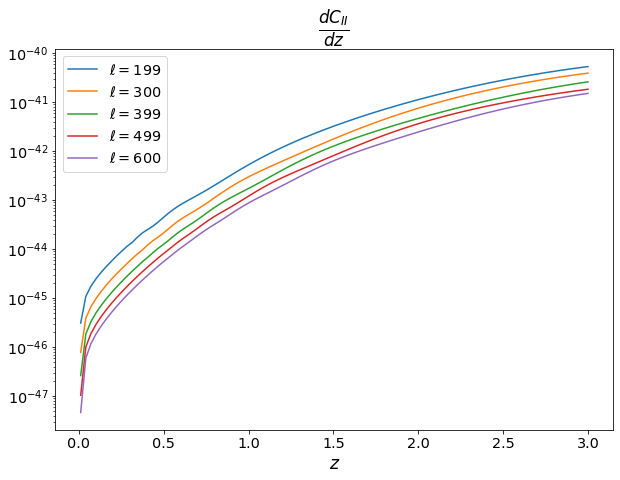

In [22]:
#Which ells to look at
test_ells = np.array([2.0e2, 3.0e2, 4.0e2, 5.0e2, 6.0e2])

#Plot
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Plot
    plt.semilogy(redshifts, Cii_integrand[i, :], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC_{II}}{dz}$', fontsize=24)
    plt.legend()
plt.savefig('dCdz_ii_l.png', dpi=500, bbox_inches='tight');

# Lensing x Lensing

## $\frac{dC_{\kappa \kappa}}{dz} (\ell, z)$

First, let's add to the model.

In [10]:
#Add to the model
zsource = 1.0 # delta-function source population
ngal = 1e-4 # number density of lenses per mpc3 (to solve for stellar mass threshold in HOD)
hcos.add_hod("g",ngal=ngal+redshifts*0.,corr="max")
hcos.add_battaglia_profile("electron",family="AGN",xmax=50,nxs=30000)

Bisection search converged in  19  iterations.


/home/yogesh/Git/hmvec/hmvec/hmvec.py:667: RuntimeWarning: divide by zero encountered in true_divide
  ret = Ns**2./Nc
/home/yogesh/Git/hmvec/hmvec/hmvec.py:667: RuntimeWarning: invalid value encountered in true_divide
  ret = Ns**2./Nc
/home/yogesh/Git/hmvec/hmvec/fft.py:90: RuntimeWarning: divide by zero encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]
/home/yogesh/Git/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


Now we can actually calculate all of the power spectra.

In [11]:
#Power Spectra
Pnn = hcos.get_power("nfw",verbose=False)
Pne = hcos.get_power("nfw","electron",verbose=False )
Pee = hcos.get_power("electron","electron",verbose=False )
Pmm = hcos.total_matter_power_spectrum(Pnn,Pne,Pee)

#Limber Integrals
Ckk0, Ckk0_integrand = hcos.C_kk(ells,redshifts,ks,Pnn,lzs1=zsource,lzs2=zsource, dcdzflag=True)
Ckk, Ckk_integrand = hcos.C_kk(ells,redshifts,ks,Pmm,lzs1=zsource,lzs2=zsource, dcdzflag=True)

And finally, plot the integrand of the limber integral.

The first is $C/C_0$.

/home/yogesh/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


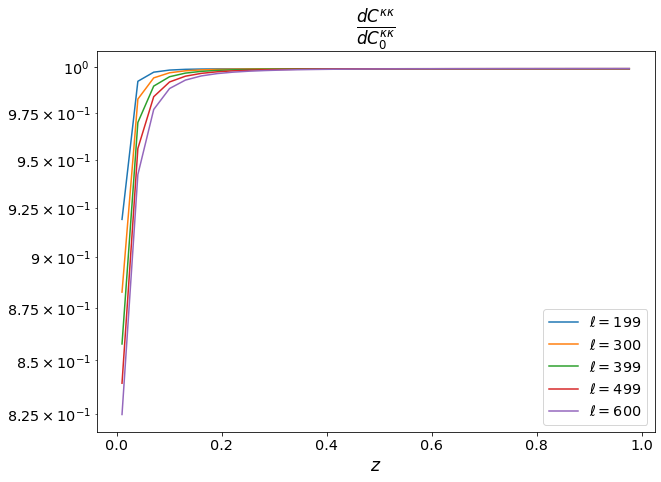

In [21]:
plt.figure(figsize=(10,7))

for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Plot
    plt.semilogy(redshifts, Ckk_integrand[i, :]/Ckk0_integrand[i, :], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC^{\kappa \kappa}}{dC^{\kappa \kappa}_0}$', fontsize=24)
    plt.legend()

plt.savefig('dCdz_kk_l0.png', dpi=500, bbox_inches='tight');

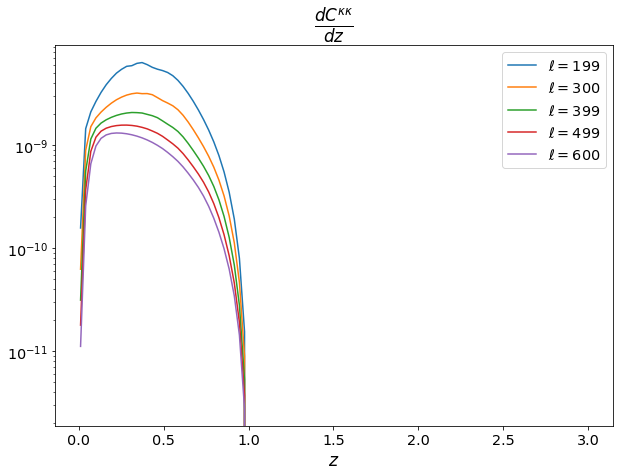

In [23]:
#Plot
plt.figure(figsize=(10,7))

for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Plot
    plt.semilogy(redshifts, Ckk_integrand[i, :], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.title(r'$\frac{dC^{\kappa \kappa}}{dz}$', fontsize=24)
    plt.legend()
    
plt.savefig('dCdz_kk_l.png', dpi=500, bbox_inches='tight');

### 2D Power Spectrum

Let's now manually integrate the integrand w.r.t. redshift to see if we get back our 2D power spectrum.

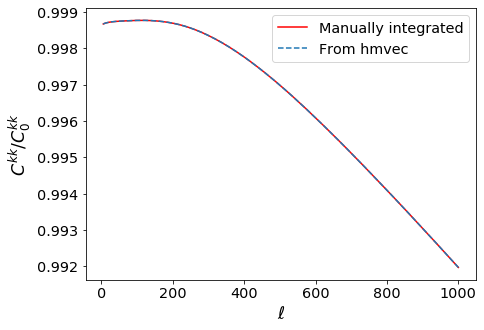

In [31]:
#Integrate
Ckk_man = np.trapz(Ckk_integrand, redshifts, axis=1)
Ckk0_man = np.trapz(Ckk0_integrand, redshifts, axis=1)

#Plot
plt.figure(figsize = (7,5))
plt.plot(ells, Ckk_man/Ckk0_man, color='red', label='Manually integrated')
plt.plot(ells, Ckk/Ckk0, ls='--', label='From hmvec')
plt.ylabel(r"$C^{kk}/C^{kk}_{0}$")
plt.xlabel(r"$\ell$")
plt.legend()

plt.savefig('Ckk_compare.png', dpi=500, bbox_inches='tight');

We see that we are indeed looking at the correct integrand.